In [2]:
# Enable current type hints for older Python version (<3.10) 
from __future__ import annotations
import boto3
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

# Read data
See the "data-pipeline" directory for how to get and persist the data as parquet.

In [3]:
# !conda install -c conda-forge  -y python-dotenv

In [4]:
from dotenv import dotenv_values

config = dotenv_values(".env")  # config = {"USER": "foo", "EMAIL": "foo@example.org"}

BUCKET_NAME = config['BUCKET_NAME']
PREFIX = config['PREFIX']
FILE_NAME = config['FILE_NAME']

In [5]:
s3 = boto3.client('s3')
s3.download_file(
    Bucket=BUCKET_NAME, 
    Key=f'{PREFIX}/{FILE_NAME}', 
    Filename=FILE_NAME
)

In [6]:
df = pq.read_table('df.parquet')
df = df.to_pandas()
df.iloc[1:3, :]

,replied_to,sender,body,timestamp
183cb6c70075704b,False,Anthem-healthspendingaccounts@mail2.anthem.com,[http://images.myhealthyfinances.com/EloquaIma...,1665565214000
183ca91acbdcd4f8,False,FloTechnologies <no-reply@meetflo.com>,\n\n\n\n\nWarning:\r\n Low Battery\r\n \...,1665550886000


In [7]:
len(df)

26695

# Clean and transform data

## Drop rows
ToDo: Do this as part of the data pipeline.

In [8]:
# Drop emails frowarded from my other inbox
df.loc[df.sender.str.contains('loeberthomas@yahoo.com'), 'replied_to'] \
    .value_counts()

False    388
Name: replied_to, dtype: int64

In [9]:
df = df.loc[
    ~df.sender.str.contains('loeberthomas@yahoo.com'),
    :
]

In [10]:
# Drop emails whith empty body
df = df.loc[
    df.body.map(len) > 0,
    :
]

## Text preprocessing
In this step, we put the data in the format required by the blazing text algorithm.

In [11]:
import nltk
nltk.download("punkt")

def create_target(s):
    """Target as required by Blazing Text."""
    label = "reply" if s == True else "no_reply"
    return f'__label__{label}'
    
# Convert training data into right format for tensorflow
def strip_non_ascii_chars(string_: str) -> str:
    return string_.encode('ascii', errors='ignore').decode()

def replace_chars_for_csv(string_: str) -> str:
    return string_.replace('\n', ' ') \
        .replace(',', ' ')

def tokenize(s):
    token_list = nltk.word_tokenize(s)
    return ' '.join(token_list)

df['target'] = df.replied_to.map(create_target)
df.target.value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


__label__no_reply    24234
__label__reply         261
Name: target, dtype: int64

In [12]:
df['feature'] = df.body.map(strip_non_ascii_chars) \
    .map(replace_chars_for_csv) \
    .map(tokenize)

In [13]:
df[['target', 'feature']].head(3)

,target,feature
183cbf647a8af438,__label__no_reply,Good morning families - The technician is here...
183cb6c70075704b,__label__no_reply,[ http : //images.myhealthyfinances.com/Eloqua...
183ca91acbdcd4f8,__label__no_reply,Warning : Low Battery Warning : Low Battery Vi...


In [14]:
assert df.isnull().sum().sum() == 0
assert df.feature.str.contains(',').sum() == 0
assert df.feature.str.contains('\n').sum() == 0

# Split data
Since this data has a time component, we don't randomly split the data. Instead, we make sure to assess the model performance on data that is newer than any data the model has seen during training. This more closely mirrors the situation in production.

Note that we have to follow this principle twice: We make sure that the validation data is newer than the training data, and that the test data is newer than the validation data.

In [15]:
# Specify split proportion, then identify corresponding timestamp and split.
TRAIN_PROPORTION = 0.75
VAL_PROPORTION = 0.1
test_proportion = 1 - TRAIN_PROPORTION - VAL_PROPORTION
assert test_proportion > 0
assert test_proportion < 1

train_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION)
val_cutoff = np.quantile(df.timestamp, q=TRAIN_PROPORTION+VAL_PROPORTION)

def split_dataset(ts):
    if ts < train_cutoff:
        return 'train'
    elif ts > val_cutoff:
        return 'test'
    else:
        return 'val'
    

df['split'] = df.timestamp.map(split_dataset)

counts = df.groupby(['split', 'target']).feature \
    .count() \
    .reset_index()
counts

,split,target,feature
0,test,__label__no_reply,3632
1,test,__label__reply,43
2,train,__label__no_reply,18176
3,train,__label__reply,195
4,val,__label__no_reply,2426
5,val,__label__reply,23


## Oversample minority class
Most emails do not elicit a reply (see barplot below); therefore, maximizing accuracy would probably be misleading. It's easy to get high accuracy simply by predicting that no email will receive a reply.

However, since the blazing text algorithm does not allow specifying a different metric to optimize (e.g., F1-score), I simply transform this problem into a balance classification problem by randomly oversampling emails that elicited a reply.

No handles with labels found to put in legend.


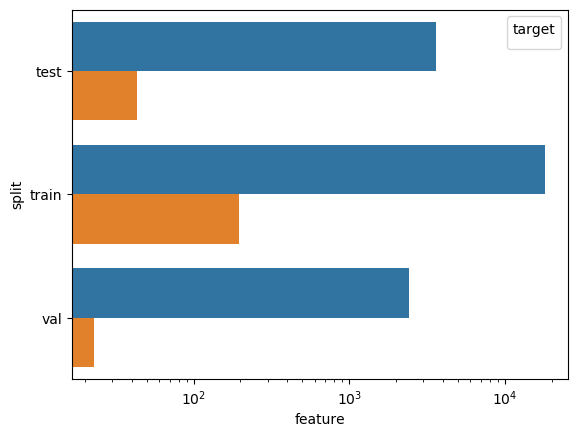

In [16]:
p = sns.barplot(data=counts, y='split', x='feature', hue='target', orient='h', errwidth=0)
p.set_xscale('log')
plt.show()

In [17]:
# pip install imblearn --quiet

In [18]:
from imblearn.over_sampling import RandomOverSampler

def oversample(df: pd.DataFrame) -> pd.DataFrame:
    max_label_count = df.target \
        .value_counts() \
        .max()

    ros = RandomOverSampler(
        random_state=1, 
        sampling_strategy={
            '__label__no_reply': max_label_count,
            '__label__reply': max_label_count,
        }    
    )
    X_os, y_os = ros.fit_resample(X=df[['feature']], y=df[['target']])

    df_os = pd.DataFrame(
        {
            'target': y_os.target,
            'feature': X_os.feature,
        }
    )
    return df_os

df_train = df.loc[df.split == 'train', ['target', 'feature']]
df_val = df.loc[df.split == 'val', ['target', 'feature']]
df_test = df.loc[df.split == 'test', ['target', 'feature']]

df_train_os = oversample(df_train)
df_train_os.target.value_counts()

__label__no_reply    18176
__label__reply       18176
Name: target, dtype: int64

In [20]:
df_val_os = oversample(df_val)
df_val_os.target.value_counts()

__label__no_reply    2426
__label__reply       2426
Name: target, dtype: int64

# Write input data
While CSV is not the most efficient format, it is the only format that the blazing text algorithm accepts. Let's write the different data sets required and upload them to S3.

In [21]:
# Todo: Persist in feature store for tracking versions
INPUT_FILENAME = 'input-blazing-text.csv'

train_key = f'{PREFIX}/train/{INPUT_FILENAME}'
val_key = f'{PREFIX}/validation/{INPUT_FILENAME}'
test_key = f'{PREFIX}/test/{INPUT_FILENAME}'

input_path_train = f's3://{BUCKET_NAME}/{PREFIX}/train'  # For Sagemaker
input_path_val = f's3://{BUCKET_NAME}/{PREFIX}/validation'  # For Sagemaker
input_path_val = f's3://{BUCKET_NAME}/{PREFIX}/test'  # For Sagemaker

output_path = f's3://{BUCKET_NAME}/{PREFIX}/output'  # For Sagemaker

def upload_data(df: pd.DataFrame, folder) -> str:
    # train
    print(f'Breakdown for {folder}: {df.target.value_counts()}')
    df.to_csv(INPUT_FILENAME, index=False, header=False, sep=' ')
    
    s3_key = f'{PREFIX}/{folder}/{INPUT_FILENAME}'
    s3_folder_path = f's3://{BUCKET_NAME}/{PREFIX}/{folder}'
    s3.upload_file(
        Filename=INPUT_FILENAME,
        Bucket=BUCKET_NAME,
        Key=s3_key
    )
    print(f'Uploaded to {s3_folder_path}\n')
    return s3_folder_path

train_path_base = upload_data(df_train, 'train/base')
val_path_base = upload_data(df_val, 'validation')

train_path_os = upload_data(df_train_os, 'train/os')
val_path_os = upload_data(df_val_os, 'validation/os')

Breakdown for train/base: __label__no_reply    18176
__label__reply         195
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/train/base

Breakdown for validation: __label__no_reply    2426
__label__reply         23
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/validation

Breakdown for train/os: __label__no_reply    18176
__label__reply       18176
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/train/os

Breakdown for validation/os: __label__no_reply    2426
__label__reply       2426
Name: target, dtype: int64
Uploaded to s3://sagemaker-data-and-models/email-classification/validation/os



In [22]:
# Persist test data for other notebook
import pickle
with open('df_test.pickle', 'wb') as f:
    pickle.dump(obj=df_test, file=f)